In [31]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

[INFO] Copying dataset 'mahmudulhaqueshawon/cat-image' to ../data/raw_data...
[INFO] Dataset ready at ../data/raw_data


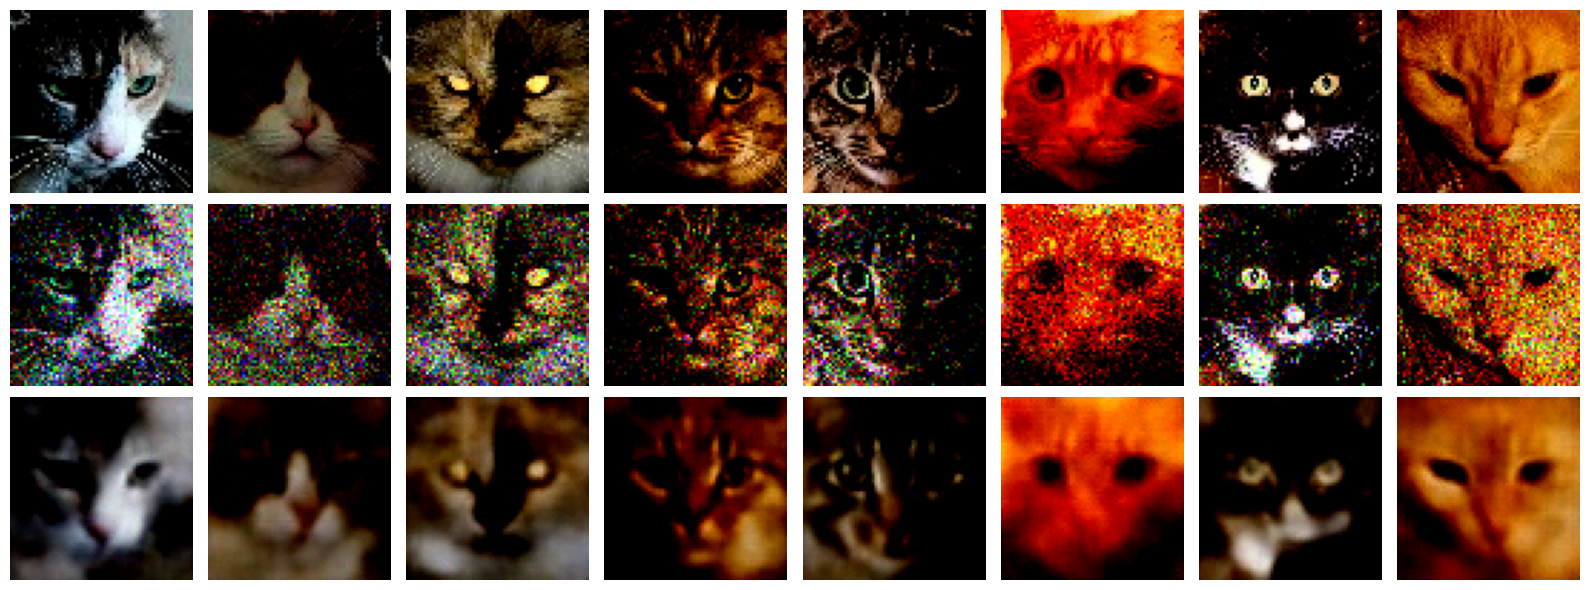

In [ ]:
import torch
from src.scripts.etl_process.ETLProcessor import ETLProcessor
from src.scripts.training.NoiseDataset import NoisyDataset
from src.models.vae.vae import VAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(
        input_dim=3,
        hidden_dim=128,
        residual_hiddens=64,
        num_residual_layers=2,
        latent_dim=256,
)
model.load_state_dict(torch.load("../models/test_run/test_vae_event0.pt", map_location=device))
model = model.to(device)
model.eval()

etl = ETLProcessor(
    kaggle_dataset="mahmudulhaqueshawon/cat-image",
    raw_dir="../data/raw_data",
    split_dir="../data/data_splits",
)
train_loader, val_loader, test_loader = etl.process()

noise_level = 0.3
noisy_dataset = NoisyDataset(test_loader, noise_level=noise_level)
noisy_loader = torch.utils.data.DataLoader(noisy_dataset, batch_size=8, shuffle=True, num_workers=0)


noisy_img, clean_img = next(iter(noisy_loader))
noisy_imgs = noisy_img.to(device)
original_imgs = clean_img.to(device) 

with torch.no_grad():
    reconstructed = model(noisy_imgs)

reconstructed = reconstructed["recon"]

def show_images(original, noisy, reconstructed, n=8):
    import numpy as np
    import matplotlib.pyplot as plt

    n = min(n, original.size(0), noisy.size(0), reconstructed.size(0))

    fig, axes = plt.subplots(3, n, figsize=(n * 2, 6))

    if isinstance(axes, np.ndarray) and axes.ndim == 1:
        axes = axes.reshape(3, -1)

    for i in range(n):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[0, i].axis("off")

        axes[1, i].imshow(noisy[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[1, i].axis("off")

        axes[2, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().clip(0, 1).numpy())
        axes[2, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Noisy", fontsize=12)
    axes[2, 0].set_ylabel("Reconstructed", fontsize=12)

    plt.tight_layout()
    plt.show()

show_images(original_imgs, noisy_imgs, reconstructed, n=8)
